# 📈 Comparação de Modelos: Recursivo vs Seq2Seq para Previsão de Carga Energética

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Carregar dados
df = pd.read_csv("../data/curva_carga_ho_2000_2025.csv", index_col=0, parse_dates=True)
col = "Sudeste"
data = df[[col]]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)


## 🔁 Modelo Recursivo (24h entrada → 1h saída, repetido 24x)

In [2]:
# Preparar dados
X_rec, y_rec = [], []
for i in range(len(scaled) - 24):
    X_rec.append(scaled[i:i+24])
    y_rec.append(scaled[i+24])
X_rec, y_rec = np.array(X_rec), np.array(y_rec)
X_rec = X_rec.reshape((X_rec.shape[0], 24, 1))

# Treinar modelo
model_rec = Sequential([
    LSTM(64, input_shape=(24,1)),
    Dense(1)
])
model_rec.compile(optimizer='adam', loss='mse')
start_train_rec = time.time()
model_rec.fit(X_rec, y_rec, epochs=20, batch_size=32, verbose=1)  # type: ignore
end_train_rec = time.time()
print(f"⏱️ Tempo de treino: {end_train_rec - start_train_rec:.2f} segundos")

# Previsão recursiva
last_sequence = scaled[-24:].reshape(1, 24, 1)
preds = []
start_pred_rec = time.time()
for _ in range(24):
    pred = model_rec.predict(last_sequence, verbose=1)[0,0]  # type: ignore
    preds.append(pred)
    last_sequence = np.append(last_sequence[:,1:,:], [[[pred]]], axis=1)
end_pred_rec = time.time()
print(f"⏱️ Tempo de previsão: {end_pred_rec - start_pred_rec:.4f} segundos")
preds_inv = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
print(preds_inv)


c:\Users\JeanCarlosMachado\Documents\Github\TCC\tcc_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - loss: 0.0030
Epoch 2/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 68s 10ms/step - loss: 2.6080e-04
Epoch 3/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 71s 10ms/step - loss: 1.6287e-04
Epoch 4/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - loss: 1.3351e-04
Epoch 5/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - loss: 1.2065e-04
Epoch 6/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 91s 13ms/step - loss: 1.0984e-04
Epoch 7/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 73s 10ms/step - loss: 9.8211e-05
Epoch 8/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - loss: 9.1733e-05
Epoch 9/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 71s 10ms/step - loss: 8.5081e-05
Epoch 10/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - loss: 7.8081e-05
Epoch 11/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 101s 14ms/step - loss: 7.3874e-05
Epoch 12/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 94s 13ms/step - loss: 7.0413e-05
Epoch 13/20
6975/6975 ━━━━━━━━━━━━━━━━━━━━ 96s 14ms/step - loss: 6.8091e-05
Epoch 14/20
6975/6975 ━━

## 📦 Modelo Seq2Seq (24h entrada → 24h saída)

In [3]:
# Preparar dados seq2seq
X_seq, y_seq = [], []
for i in range(len(scaled) - 48):
    X_seq.append(scaled[i:i+24])
    y_seq.append(scaled[i+24:i+48])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
X_seq = X_seq.reshape((X_seq.shape[0], 24, 1))
y_seq = y_seq.reshape((y_seq.shape[0], 24, 1))

# Treinar modelo Seq2Seq
model_seq = Sequential([
    LSTM(64, input_shape=(24,1)),
    RepeatVector(24),
    LSTM(64, return_sequences=True),
    TimeDistributed(Dense(1))
])
model_seq.compile(optimizer='adam', loss='mse')
start_train = time.time()
model_seq.fit(X_seq, y_seq, epochs=20, batch_size=32, verbose=1)  # type: ignore
end_train = time.time()
print(f"⏱️ Tempo de treino: {end_train - start_train:.2f} segundos")

# Previsão seq2seq
input_seq = scaled[-48:-24].reshape(1, 24, 1)
start_pred_seq = time.time()
pred_seq = model_seq.predict(input_seq, verbose=1).reshape(24)  # type: ignore
end_pred_seq = time.time()
print(f"⏱️ Tempo de previsão: {end_pred_seq - start_pred_seq:.4f} segundos")
pred_seq_inv = scaler.inverse_transform(pred_seq.reshape(-1, 1)).flatten()
print(pred_seq_inv)


Epoch 1/20


c:\Users\JeanCarlosMachado\Documents\Github\TCC\tcc_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6974/6974 ━━━━━━━━━━━━━━━━━━━━ 153s 21ms/step - loss: 0.0069
Epoch 2/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 145s 21ms/step - loss: 0.0018
Epoch 3/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 205s 21ms/step - loss: 0.0013
Epoch 4/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 180s 26ms/step - loss: 0.0011
Epoch 5/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 192s 28ms/step - loss: 0.0010
Epoch 6/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 196s 28ms/step - loss: 9.2364e-04
Epoch 7/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 197s 28ms/step - loss: 8.4659e-04
Epoch 8/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 202s 29ms/step - loss: 7.7857e-04
Epoch 9/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 179s 26ms/step - loss: 7.2998e-04
Epoch 10/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 161s 23ms/step - loss: 6.8902e-04
Epoch 11/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 193s 28ms/step - loss: 6.6361e-04
Epoch 12/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 171s 23ms/step - loss: 6.3872e-04
Epoch 13/20
6974/6974 ━━━━━━━━━━━━━━━━━━━━ 189s 27ms/step - loss: 6.2134e-04
Epoch 14/20
6974/6974 ━━━━━━━━━━━━━━━━━

## 📊 Comparação das Métricas

In [4]:
# Valores reais
y_true = data[col].iloc[-24:].values

# Função de avaliação
def calcular_metricas(y_true, y_pred, nome_modelo):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100
    print(f"\n📊 Métricas para o modelo: {nome_modelo}")
    print(f"MAE :  {mae:.2f}")
    print(f"MSE :  {mse:.2f}")
    print(f"RMSE:  {rmse:.2f}")
    print(f"MAPE:  {mape:.2f}%")

# Avaliação
calcular_metricas(y_true, preds_inv, "Recursivo")
calcular_metricas(y_true, pred_seq_inv, "Seq2Seq")



📊 Métricas para o modelo: Recursivo
MAE :  5322.51
MSE :  37203456.39
RMSE:  6099.46
MAPE:  12.14%

📊 Métricas para o modelo: Seq2Seq
MAE :  517.59
MSE :  363309.83
RMSE:  602.75
MAPE:  1.28%


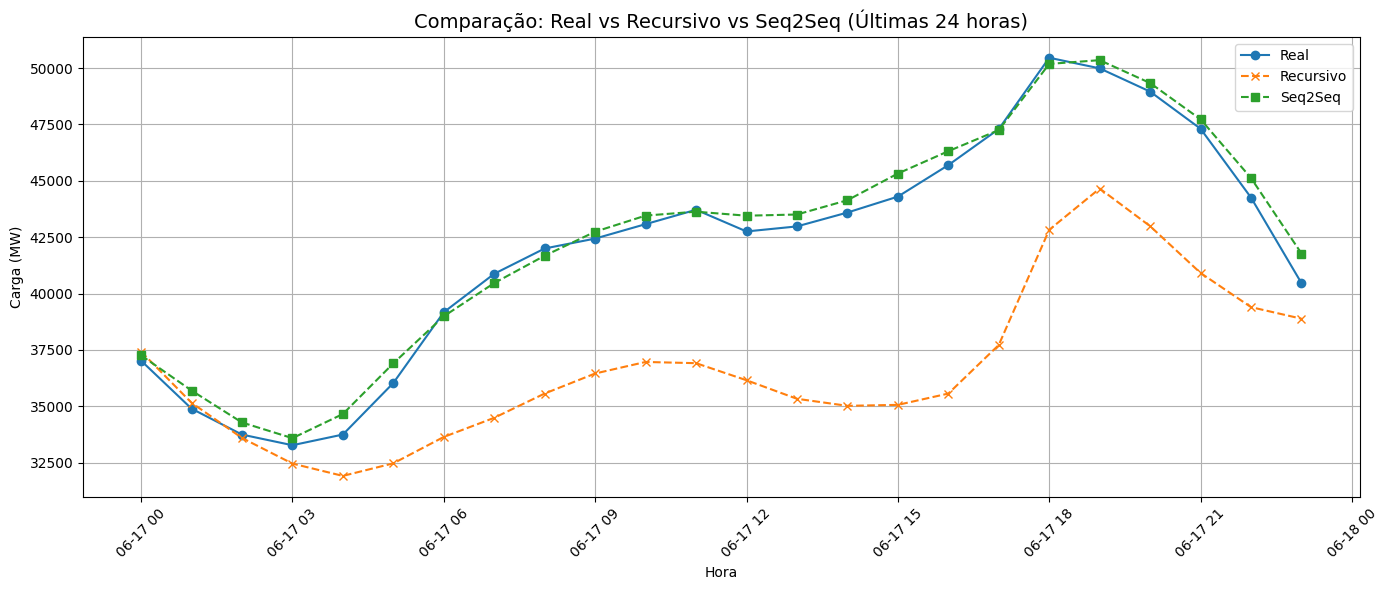

In [6]:
import matplotlib.pyplot as plt

# Criar eixo de tempo (últimos 24 timestamps)
eixo_tempo = data.index[-24:]

# Plotar
plt.figure(figsize=(14, 6))
plt.plot(eixo_tempo, np.asarray(y_true), label='Real', marker='o')
plt.plot(eixo_tempo, np.asarray(preds_inv), label='Recursivo', linestyle='--', marker='x')
plt.plot(eixo_tempo, np.asarray(pred_seq_inv), label='Seq2Seq', linestyle='--', marker='s')

plt.title("Comparação: Real vs Recursivo vs Seq2Seq (Últimas 24 horas)", fontsize=14)
plt.xlabel("Hora")
plt.ylabel("Carga (MW)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()